### Overview:
This notebook provides ways to identify whether a specific gene is overrepresented in any communities. The results from these analyses are presented on our webpage "gene-level" tab. There are two main methods we used:
- Overrepresented genes (statistical test) - here, we use a one-way chi square test to identify whether there are communities that contain an above-random number of appearances of the gene (i.e, the gene is not evenly appearing across pathways among communities) 
- Fractional assignments - here, we just perform simple calculations to see what fraction communities contain each gene


For examples of querying a gene, see the last section of the notebook titled "Examples". The user may try querying different genes by replacing "APOE" with other genes of interest.

In [1]:
import numpy as np
import os
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import chisquare
import utils

%matplotlib inline

## Load gene sets

In [2]:
acronym_to_folder = {"KEGG": "c2.all.v7.0.symbols_JustK", "REACTOME":"c2.all.v7.0.symbols_JustR",
                  "GO_BP": "c5.bp.v7.0.symbols_SHORT", "GO_CC": "c5.cc.v7.0.symbols", "GO_MF": "c5.mf.v7.0.symbols"}
folder_to_acronym = utils.reverse_dict(acronym_to_folder, assume_unique = True)

pway_subfolders =  'c2.all.v7.0.symbols_JustK-c2.all.v7.0.symbols_JustR-c5.bp.v7.0.symbols_SHORT-c5.mf.v7.0.symbols'

gsets_folders = pway_subfolders.split("-")
gsets_acronyms = [folder_to_acronym[x] for x in gsets_folders]

In [7]:
pathways = {}
pway_indices = {}
cur_idx = 0
for foldername in gsets_folders:
    name = folder_to_acronym[foldername]
    pathways[name] = np.loadtxt('../adj_matrices/%s/pathway_names.txt'%foldername, dtype=str)
    pway_indices[name] = np.arange(cur_idx, cur_idx + len(pathways[name])).astype(int)
    cur_idx += len(pathways[name])
pathway_names = np.hstack([pathways[name] for name in gsets_acronyms])


gmts, true_labels_unique, true_labels, true_labels_names= utils.load_curated_labels(pway_dbs=gsets_acronyms)
pathway_names_curated_categories =  np.hstack([true_labels_names[name] for name in gsets_acronyms])

Number of true categories:  38
[ 1.  3.  4.  5.  6.  7.  8.  9. 16. 17. 21. 22. 23. 24. 25. 26. 27. 28.
 29. 30. 31. 32. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 54. 55.
 56. 57.]
Number of true categories:  27
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26.]
Number of true categories:  64
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63.]
Number of true categories:  69
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68.]


## load community labels

In [8]:
new_com_df = pd.read_csv("../Full_graph_louvain_with_weights_community_labels/0.4/labels.tsv", delimiter="\t", names=["pathways", "com"])
new_com_df = new_com_df.merge(pd.DataFrame(pathway_names.reshape(len(pathway_names),1), columns=["pathways"]), how="right", on="pathways")
coms = new_com_df["com"].values

In [9]:
com_membership_for_appendix=new_com_df[["com", "pathways"]].sort_values("com")
com_membership_for_appendix["com"] += 1

sizes=[]
for com in np.unique(coms):
    pway_idx = np.where(coms==com)
    pways_in_com = pathway_names[pway_idx]
    
    sizes.append(len(pways_in_com)) 

# Overrepresented genes (statistical test)

In [10]:
gmts_concat = pd.concat(list(gmts.values()))
pways_gmts = pd.DataFrame(pathway_names, columns = ["names"]).merge(gmts_concat, on="names", how="left").reindex()
total_genes, total_gene_counts = np.unique(np.hstack(pways_gmts["genes"].values), return_counts=True)

In [11]:
community_gene_counts = np.zeros([len(np.unique(coms)), len(total_genes)])
for com in np.unique(coms):
    pway_idx = np.where(coms==com)
    pways_in_com = pathway_names[pway_idx]
    
    pways_gmts_com = pways_gmts.iloc[pway_idx]
    
    g, c  = np.unique(np.hstack(pways_gmts_com["genes"].values), return_counts=True)
    for i, g_name in enumerate(g):
        community_gene_counts[com, np.where(total_genes==g_name)[0][0]] = c[i]

In [12]:
total_genes_repeated = np.repeat(total_gene_counts.reshape(1,-1), len(sizes), axis=0) 
size_fracs = np.array(np.array(sizes) / sum(sizes))
null_expected_counts = np.multiply(total_genes_repeated, size_fracs.reshape(-1,1))

In [13]:
# calculate "# of pathways without gene" for one way chi-square test -- observed & expected
actual_not_gene = community_gene_counts.sum(axis=0) - community_gene_counts
exp_not_gene = total_gene_counts - null_expected_counts

num_coms, num_genes = community_gene_counts.shape

chi_test_val = np.zeros([num_coms,num_genes])
chi_test_pval = np.ones([num_coms,num_genes])

for i in range(num_coms):
    if i % 10==0:
        print(i)
    for j in range(num_genes):
        
        # One way chi square:
        #   f_obs:  [ # pathways in community with gene,  # pathways in community without gene],
        #   f_exp:  [expected pathways in community with gene,  expected pathways in community without gene]
        #           we calculate f_exp so it's proportional to the size of the community

        chi_test_val[i,j], chi_test_pval[i,j] = chisquare([community_gene_counts[i,j], actual_not_gene[i,j]], f_exp=[null_expected_counts[i,j], exp_not_gene[i,j]])

0
10
20
30


In [14]:
df_rows = []
sig_idxes = np.where(chi_test_pval * chi_test_pval.shape[0] * chi_test_pval.shape[1] < .05)
for idx in range(len(sig_idxes[0])):
    i = sig_idxes[0][idx]
    j = sig_idxes[1][idx]
    
    # filter out "lower than expected" genes
    if community_gene_counts[i,j] > null_expected_counts[i,j]:
        df_rows.append([i+1,j, community_gene_counts[i,j], total_gene_counts[j], chi_test_val[i,j], chi_test_pval[i,j], size_fracs[i], sizes[i]])

sig_genes_df = pd.DataFrame(np.array(df_rows), columns=["com", "gene_idx", "counts_in_com", "total_gene_appearances", "stat", "pval", "com_size_frac", "com_size"] )
sig_genes_df["gene"] = sig_genes_df["gene_idx"].apply(lambda x: total_genes[int(x)])

In [15]:
def query_gene(g):
    return sig_genes_df[sig_genes_df["gene"]==g].sort_values("pval")

In [16]:
# sig_genes_df.to_csv("appendix_tables/significant_genes.csv")

### Format results for appendix tables

In [17]:
# sig_genes_df = pd.read_csv("significant_genes.csv", index_col=0)
sig_genes_df["pval_corrected"] = sig_genes_df["pval"] * len(total_genes) * len(np.unique(coms))
to_save = sig_genes_df[sig_genes_df["pval_corrected"]<.01].sort_values(["com", "pval_corrected"])

In [18]:
# to_save[["com", "gene",'pval_corrected', "counts_in_com", 
#          "com_size", 'total_gene_appearances']].to_csv("appendix_tables/significantly_overrepresented_genes.csv", index=False)

# Fractional assignments
- "specificity"(frac_gene_assignments[c,g]): what fraction of gene g's appearances are in community c
- "com_frequency" (freq_normed_by_com_size[c,g]:  normalized version of "specificity" which takes the size of the communities into account


In [19]:
frac_gene_assignments = community_gene_counts/total_gene_counts
com_sizes = np.unique(coms, return_counts=True)[1]

In [20]:
freq_normed_by_com_size = np.zeros(frac_gene_assignments.shape)
for g_idx in range(len(total_genes)):
    prop = frac_gene_assignments[:,g_idx] / com_sizes
    freq_normed_by_com_size[:,g_idx] = prop/np.sum(prop)

In [21]:
representative_genes = []

for c in np.unique(coms):
    sorted_gene_ids = np.argsort(frac_gene_assignments[c])[::-1]
    
    above0 =len(np.where(frac_gene_assignments[c] > 0)[0])
    g_ids = sorted_gene_ids[:above0]

    representative_genes.append(pd.DataFrame(np.vstack([total_genes[g_ids], freq_normed_by_com_size[c][g_ids], 
            frac_gene_assignments[c][g_ids], community_gene_counts[c][g_ids]]).T,
            columns = ["gene", "com_frequency", "specificity", "raw_count"]))

In [22]:
# SAVE ALL GENE-COMMUNITY STATISTICS

frac_pways_w_gene = community_gene_counts/com_sizes.reshape(-1,1)
frac_pways_w_gene_df = pd.DataFrame(frac_pways_w_gene, columns=total_genes)
frac_pways_w_gene_df["community"]=np.unique(coms)+1

frac_gene_assignments_df =  pd.DataFrame(frac_gene_assignments, columns=total_genes)
frac_gene_assignments_df["community"]=np.unique(coms)+1

frac_gene_assignments_normedbysize_df =  pd.DataFrame(freq_normed_by_com_size, columns=total_genes)
frac_gene_assignments_normedbysize_df["community"]=np.unique(coms)+1

# if not os.path.isdir("appendix_tables/gene_level_info/"):
#     os.makedirs("appendix_tables/gene_level_info/")
    
# frac_pways_w_gene_df.to_csv("appendix_tables/gene_level_info/frac_pways_w_gene.csv", index=False)
# frac_gene_assignments_df.to_csv("appendix_tables/gene_level_info/frac_gene_assignments.csv", index=False)
# frac_gene_assignments_normedbysize_df.to_csv("appendix_tables/gene_level_info/frac_gene_assignments_normedbysize.csv", index=False)


In [23]:
com_rep_genes = []
for i,rg in enumerate(representative_genes):
    rg["community"] = i+1
    rg['community_size'] = com_sizes[i]
    com_rep_genes.append(rg)
com_rep_genes = pd.concat(com_rep_genes, ignore_index=True)

In [24]:
def query_gene_nonstat(g) :
    return com_rep_genes[com_rep_genes["gene"]==g].sort_values("com_frequency", ascending=False)

## Examples
- query_gene: gives communities with statistically significant over-representation of the gene
- query_gene_nonstat: gives all communities sorted by frequency (normalized by community size)

0.883107 of genes have a query result


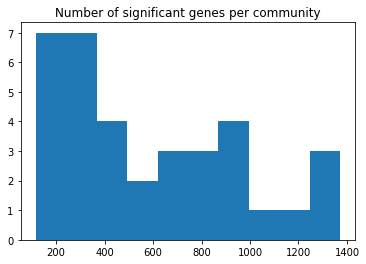

In [25]:
plt.hist(sig_genes_df["com"].value_counts())
plt.title("Number of significant genes per community")

print("%f of genes have a query result"%(len(np.unique(sig_genes_df["gene"]))/len(total_genes)))

In [26]:
query_gene("TP53")

,com,gene_idx,counts_in_com,total_gene_appearances,stat,pval,com_size_frac,com_size,gene,pval_corrected
17332,27.0,15742.0,22.0,193.0,93.560576,3.939569e-22,0.018981,92.0,TP53,2.432290e-16
10321,16.0,15742.0,24.0,193.0,72.011398,2.139580e-17,0.026408,128.0,TP53,1.320977e-11
16277,26.0,15742.0,29.0,193.0,51.922019,5.774918e-13,0.043945,213.0,TP53,3.565434e-07


In [27]:
query_gene_nonstat("APOE")

,gene,com_frequency,specificity,raw_count,community,community_size
27533,APOE,0.25043762637775846,0.32934131736526945,55.0,9,183
66125,APOE,0.11260463299049091,0.11976047904191617,20.0,21,148
69909,APOE,0.07245863340257674,0.03592814371257485,6.0,22,69
75733,APOE,0.07183399001117523,0.029940119760479042,5.0,24,58
93282,APOE,0.06097128908265605,0.03592814371257485,6.0,29,82
60676,APOE,0.05318772026359358,0.017964071856287425,3.0,19,47
44882,APOE,0.04463969379265889,0.05389221556886228,9.0,14,168
59134,APOE,0.04006126366007849,0.029940119760479042,5.0,18,104
26520,APOE,0.038938050660263214,0.029940119760479042,5.0,8,107
73606,APOE,0.03787610382407421,0.011976047904191617,2.0,23,44
